In [1]:
%cd supervised
%load_ext autoreload
%autoreload 2

import data
import train
import evaluate
import models
import torch
import seaborn as sns

/home/maarten/Documents/masterthesis/supervised


In [12]:
import pickle

def save(data, fname):
    with open(fname, 'wb') as f:
        pickle.dump(data, f)
    
def load(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)

In [2]:
dataset1, validset1, testset1 = evaluate.load_dataset(9, 0, 1, True)
dataset2, validset2, testset2 = evaluate.load_dataset(9, 1, 1, True)

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  5.08it/s]


In [3]:
import numpy as np
from collections import Counter
print(Counter(np.shape(s.clusters_gmm)[1] for s in dataset1))
print(Counter(np.shape(s.clusters_gmm)[1] for s in dataset2))

Counter({22: 3890})
Counter({33: 3890})


In [4]:
assert(len([d.label for d in dataset1 if np.all(d.label == 1)])
       ==len([d.label for d in dataset1 if np.all(d.label == 0)]))

for d1, d2 in zip(dataset1, dataset2):
    assert(np.all([w in d2.X_words for w in np.nditer(d1.X_words)]))
    assert(np.all([w in d2.X_chars for w in np.nditer(d1.X_chars)]))
    assert(np.all(d1.label == d2.label))

# Training size, full cross validation

In [ ]:
# main test

window_size = 2
num_clusters = 9
dataset, validset = load_dataset(num_clusters, window_size)

params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=100,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

optim_fn = lambda p: torch.optim.Adadelta(p)
model_fns = [lambda r: models.NoClusterLabels(r, params.dropout),
             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout)]
#             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout)]

baseline = {}
kmeans = {}
gmm = {}

for n in [50, 100, 400, 800, 1200, 1600, 2000, 2400]:
    values = evaluate.cross_val(10, n, model_fns, [False, False], optim_fn, dataset, params,
                                early_stopping=10,
                                validation_set=validset,
                                testset=None)
    baseline[n] = [v[0] for v in values]
    kmeans[n] = [v[1] for v in values]
#    gmm[n] = [v[2] for v in values]

In [ ]:
d = {s: {'Baseline': baseline[s],
         'K-Means': kmeans[s],
#         'Mixture model': gmm[s],
        }
    for s in baseline.keys()
}
evaluate.analyze_tseries(d, 'number of training samples', 'model', '../report/figures/results/main_window4_oldtest')
evaluate.analyze_size(d, 'number of samples', 'model', '../report/figures/results/main_window4_oldtest')

In [ ]:
evaluate.analyze_wrapper(baseline, kmeans, None, 'model', '../report/figures/results/main_window4_data_oldtest')
#evaluate.analyze_wrapper(baseline, kmeans, gmm, 'model')

# Training size, older test set

In [28]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=200,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

char_params = train.CharCNNParams(
    dropout=0.5,
    epochs=200,
    max_norm=3,
)

num_clusters = 9
window_size = (0, 1)
k = 5

#old_baseline_s = {}
#old_kmeans_s = {}
#old_gmm_s = {}
#old_char_baseline_s = {}
#old_char_kmeans_s = {}
#old_char_gmm_s = {}


for training_size in [100, 200]:
    optim_fn = lambda p: torch.optim.Adadelta(p)
    model_fns = [
        lambda r: models.NoClusterLabels(r, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, num_clusters, sum(window_size) + 1, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, sum(window_size) + 1, params.dropout),
        lambda r: models.NoClusterLabels(r, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, num_clusters, sum(window_size) + 1, char_params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, sum(window_size) + 1, char_params.dropout),
    ]

    dataset, validset, testset = evaluate.load_dataset(num_clusters, window_size[0], window_size[1], True)
    splitter = evaluate.StratifiedShuffleSplit(
        n_splits=k,
        train_size=training_size,
        test_size=None,
        random_state=100,
    )

    splitter.random_state = 100
    values = evaluate.cross_val(k, splitter, model_fns, [False, False, True, False, False, True], optim_fn,
                                dataset,
                                params=[params, params, params, char_params, char_params, char_params, char_params],
                                early_stopping=2,
                                validation_set=validset,
                                batch_size=128,
                                testset=testset)
    
    old_baseline_s[training_size] = [v[0] for v in values]
    old_kmeans_s[training_size] = [v[1] for v in values]
    old_gmm_s[training_size] = [v[2] for v in values]
    old_char_baseline_s[training_size] = [v[3] for v in values]
    old_char_kmeans_s[training_size] = [v[4] for v in values]
    old_char_gmm_s[training_size] = [v[5] for v in values]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.67it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[1355  856  137 1095   94 3299 2805 1877 2139 1223 3200 3517 3846  417
 2882 2871 3233  782 3175  654 3246 3137 2587 1996  548 2657  239   57
  799 1676  765 2039  964 1883 3045 1530 1085  577 1894  269 3329 3330
 2829 1357  423 2550 1313 1783 3268 3645 3828 1343 1315 2077  552 3413
 1613 2519 3779 1153  142 2875 1274 2426 2814 1352  860 2206  353 2469
  790 2827   53 1816 2510 1712 1574 2005 2413 2460 1103 1180 2316  817
 3488 2226  684 3694 1006 1392  453 2704  467 3648  580  928  569  648
  608 2553]
100 training samples, 1132 testing samples


Training:  12%|█▏        | 24/200 [00:03<00:27,  6.46it/s, f1=0.81, Δf1=-0.0227]

 20%|██        | 1/5 [00:47<03:11, 47.92s/it]

[1320 2238 1835 3685 1745 3385 3032 1474 3205 1181 1131 3050 1524 3440
 1976  445 1811 3004  882 1959 2730 2083 2082 1223 1797  353 1988  656
  471 2589 1958  711 3868 2952   38  758 1350  394  475 1232 2147 2049
 2123 2875 3298 2880 2293 2536 2329 2543  272  681  582 1434 3258 1941
 3031  773 1307 3110 1761 1733 2981 2154 1974 1040 2164  890 3206  728
   30 2685  740 1081 1280 2274 3351 2778 2383 3411 2906 3220   41 1796
 3073 1896 3668 2963 2707  647 2760  281 1977 3880 3289 2190   84 1497
 3515 3879]


Training:   7%|▋         | 14/200 [00:02<00:30,  6.20it/s, f1=0.806, Δf1=0]     

 40%|████      | 2/5 [01:24<02:06, 42.23s/it]

[3855 2939 2051 2630 2708  606  754 2410 1675 1297 1069 3060  819 1480
 1027 2649 2568 3621 3464 2490  683 1947 1833 1141 2754 3015 1775 1956
 3813  228 1328 1706  613 1099  192 1822  625 2327  791 3637  920 1659
 3074 2061 2042 1292 2850 3648 2727 2820 2790 1343 2595  485 3105  401
 1356 2980 1154 3199  609 3842 3694 3611 1056 3652  988 1759 3634 2726
  971 3332  914 3677 1048 1816  205 2087 3791  949 3180  669 1656  123
 2906 1689  627  496 1000 3478  456 3639 1623 1342 2329 2877  195  405
 3768  139]


Training:  20%|██        | 40/200 [00:06<00:24,  6.64it/s, f1=0.849, Δf1=-0.00214]

 60%|██████    | 3/5 [02:02<01:21, 40.90s/it]

[3697  969  122  796  704 3519  961  910 1702  355 1921 2555 1865  510
  632  785 3297 2324  421 1403  406  106 1076  426  681 1682 2731 3594
  948  379 3626 1941 2021  710 3399  461 3183  963 2604  675 2350 1046
 2916  601  633 2591 1096  981 1037 3126 3026 1065 3464 1266 3815  321
 1487 3468 1359 2062 2998  721 3634  142 2614  477 3785 2967 1012  276
 1835 1048 2558 3791 1091 2364 1577  781 2333  437 1218 1495 1634 2910
  247 2130 2627 1948 2292 3750 1481 1512 3261 2841 1243 2238 1176  331
 3355 2226]


Training:   5%|▌         | 10/200 [00:01<00:28,  6.61it/s, f1=0.817, Δf1=-0.00872]

 80%|████████  | 4/5 [02:37<00:39, 39.49s/it]

[1958 1526  237 2074   98 3248 2899 2158 2897 1057 2942   74 2563 3875
 1842 2479 1827 1694 3345 3801 2265 3726  276 2309 2378 3230 1986  780
 3767 1390 3442 3251  216   75 2065 2199 1870 3322  342  249  182  495
  535 1910 2275 3734  604  576  946 1901   72  956 3315 2025 2805 2779
 3190  338  827  990 1548  996 1552 2390 2450 3477   94 3626 1210  921
 2721 2547 2919 1062  816 2333 3431 1682 2638 3775 2932 1834 2717 1978
  152 2081   27 3290 2500 1718 1800 2593  413 3396 2368 2040 3077 2794
   47  347]


Training:   8%|▊         | 15/200 [00:02<00:27,  6.77it/s, f1=0.814, Δf1=-0.00619]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.46it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[1006 1816 1173  453 3737 1233 1647 1621 1290   92 3566 1479 3517 3200
 1355 1877 1454 2532  577   17 3757 1085    8 1274 3488  204  964 3299
 3175 1894 1701 1848 3779 2149 3233  765 2077  232 1577 1530  236 3828
 2580 2480  670  118   94 1996 2596 1095  517 2316 1676 1678 2300 1263
  185 1730  417 3648 2152 1153 3245 1343 1963 1763  947 1883 2829 3045
 2017 1284  467 3594 3796 2567  548  239 2500   58 2814 3881  710 2704
 3846  580 1303  146  423 2139 3236 1223 2882  684  782 2805 2553 2510
  963 1449 2005 3137 1574 1925 2657 1315 2426 2413 3330 3329  269 2871
 3142 2875 2550  869 2714 3401   57 2599 3669 1177 1712  137 3246 1352
  569 2810 2214  726 3268 2627 1091 2160 3478 2837  799 3713 1426 1357
 3123  648 2092  552 2501 3645 2469 1612 2228  856 3129 3716  150 1313
 1783 3795  142 1214  654 1613 2150  599 2587  556 3053  860 2206 1570
 1412  790 2827   53 3752 2519  532  285 2460 1103 1180  394  817 2226
 2039  353  506 1592 3694 2735 1392 2279 3054 1767 3290 2391  928 3663
 3731 

Training:  14%|█▍        | 29/200 [00:05<00:34,  4.93it/s, f1=0.846, Δf1=-0.00426]

 20%|██        | 1/5 [00:45<03:03, 45.87s/it]

[2034 3603 2562 1624 2568  876 2199 1738 3049 2555 1437 1684 2893 2678
 2424 2410  942 1046 3206   30 3255 3788  185 2451  855 3702 1257 2528
 2443 2379 2362 3762 3036 3130 2083 1634  650 1574 1341 1833 2303 1717
  575 2198  382 1968  554  813  503  569 3521 3381  136 1610 3490 1062
  471  490 3239  969 2138 2898  728   84 2951 2552 2321 1444 3295 2348
 3328 2792 3453 1263  342 2723 2753 1349 2646 1273  900  498 3541  162
 1696  428 3095  961 1718 3155 1767 2846 3118 3561 1510 1147  534 1889
  182 3044  239 3042 1786 1526 1104 1156  541 2650  465 1811  276 2238
 3112 3115  890 3846 3726 1230 3691 1407 1578 3344  615  773  882 3406
   63 1374 1096 1827 3218 1685 2488 2675 3129 3610  586 1617  663 2213
 2925   41   38   16 3477  798  353 2737 3172  520 2574  999 2529 2053
 1201 3755 1212 1482 2978  480 1085 3156 1539 1645 3761 1567 3475 1448
  948 1823  475 2075 2299 1886  899 1318 3145 2647 3605 1040 3176  938
  941 3108 2799 3774 2290 2336 3136  445 1232 3479 2868  786 1573 1762
 2054 

Training:  45%|████▌     | 90/200 [00:17<00:21,  5.07it/s, f1=0.877, Δf1=-0.00292] 

 40%|████      | 2/5 [01:51<02:46, 55.61s/it]

[1436 1552 3671 1514 3551 2220  509 2271  622 1268 3108 3441 3269  373
  613  688 2257 3085  400  273 2098 1928 3626 1171 1753 1031 3557 2494
  192 1899  331 1350 1069 1008 1768 1032   93 3308  355  943  920 2046
 3384 2549 2099  383 1476 3116 1498 3077 3277 2559 2940 1559  120 1949
  600 3086 3162 1631 1462 2229 2736 3589 1415 3114 2127 2156 1256 1757
  468 1617  975  338 3522  700 1202 2864 3447  456 3263  242 2891  998
 3811 2215 3072 1309 2065 1388 2223  722 2264  139 2708 1185  597 3617
 1085 2580  857  842  667 3668 1956  754 2816 1059  847 2376  574 2050
 2022 2411   18  508 3365 3241 1052 2551 1470  611 2043 2890  423 2105
  596 3292  195 2114 1980 2442   51  205  686 1586 3151 1335 1503 1058
 3111 2198 1267 2832 3113 1488 3270 2994 3018 3344  416 1620 2799 1805
 1015 1475 3730 3470 2715  752 1100  228 1963 3452 2780 2214  851 3060
 2817 1166 2755 3706 1831 2242 2751  707 2233  988 2124  374 3832 2833
 1623 3519  959 2007 1319 3879  708 2019 3807 3379 3177 2846 2341 3009
 3030 

Training:  15%|█▌        | 30/200 [00:05<00:33,  5.07it/s, f1=0.798, Δf1=-0.0393]

 60%|██████    | 3/5 [02:46<01:51, 55.52s/it]

[2723 3866 2010  765  595  647 1845  430  154 2326 2078 3699  182 3752
  633 3363  309 2889  579 2133 3634 1418  519 3132  549 2299 3001 3468
 1838 1778 2305 3300  841  695  878 2096  114   86 3584  796  620 3021
 2507 3403 2064 2520 3393 3285 2954 1532  256  653 2823 2162 3201  542
 2873 2241 1375 3374 2929 3810 1028  691  645  411  331   90 3037 2038
   91 1228 1009 1359 2763 2630 2990 2559 1186 1804 3737 1695  235 2828
  815 1135  474 2647  634 1674  996 1941 1362 1139 1388 3828 2062 3025
 1027 1332 3475 2209 3251 1438 2276 1729  453 1762 1245 2109 3619  584
 3742 1953 2680 2271 1580  758 2805 2600 3782 1740 1229 2718  566 3805
  631 1960 3754 1049 2342 3686 3299  690 3566 3883 1300  668 1266  942
  445  268 2706  973 3718 2781 1219  740 1307  321 3518 3367  517 1278
 1456 2150 1224 3364 3215 1666 2568  590 2574 3413 1395 2733 1113 1760
  247 2713 2266  876    6    9 3077  521  400 2360 2356  607 1783  797
 3387 1090 1966  848 1615 3260 3064 2788  225 3323 2974  721 2067 3846
 3629 

Training:  18%|█▊        | 35/200 [00:06<00:32,  5.13it/s, f1=0.832, Δf1=-0.016]  

 80%|████████  | 4/5 [03:30<00:52, 52.63s/it]

[2904    3 1710  812  143 1304 3563 3106 3241  330 2442 3160 3711 3783
 3078  967 3773  823  273  566 3800 3401 2382 2288  515 1450 2172  368
 1890 1579  836 2580 3264  276 3614 3531 1366  943  514 1388 3585 3119
 2783 2624 3024 3725 3626   67 1784 2687 1900 2918 1655  596 3000  946
  380  565  409 3739 2677  370 1406  758 3624 1444 3102 1972 1290 3353
 1577 2645 3548 2978 1142 3580 3775 1863 3566  602 2886 3179 1997  358
 3208 3182 2187 1440  347 2887 1047 1046 1228 3149  735  392 1820 2611
 2990 1072 1232  578 2308 3071 2291 1231 1301 1733 2833 3707   72 1508
 2776 2943 2889 1269 2514  853 1783 1572 2304 2789 3858  132 3131  216
 2734 1679  549 1136 2314 2792 1592 1928 1627 3881 2561 1634  340 2626
 2509 1839  229 1881 2195 1641  888  307 3357  873 3199 1938 1946 3430
  525  194 1375 1924 2963 3719 2958 2606 2973 3255 3148  835 1081 2850
 2949 3666 2175 3769 1456 3840 1048  422 2422 2047 2882 3857 2496  489
 1623 2313 2657 1176  342 3088 1763 1171  838 3458  816 2036  469  264
 2084 

Training:  10%|█         | 20/200 [00:03<00:34,  5.19it/s, f1=0.835, Δf1=-0.0111]

100%|██████████| 5/5 [04:16<00:00, 51.36s/it]


/usr/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


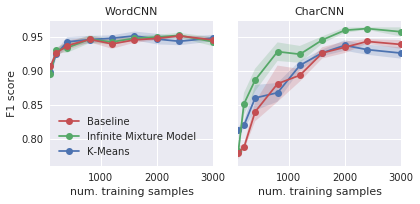

In [38]:
import seaborn as sns
d = {
    "WordCNN": {
        s: {
            'K-Means': old_kmeans_s[s],
            'Infinite Mixture Model': old_gmm_s[s],
            'Baseline': old_baseline_s[s],
        }
        for s in old_kmeans_s.keys()
    },
    "CharCNN": {
        s: {
            'K-Means': old_char_kmeans_s[s],
            'Infinite Mixture Model': old_char_gmm_s[s],
            'Baseline': old_char_baseline_s[s],
        }
        for s in old_kmeans_s.keys()
    }
}

with sns.axes_style("darkgrid"):
    #evaluate.analyze_cnns(d, "window_size", "model")
    evaluate.analyze_cnns(d, "num. training samples", "model", "../report/figures/results/training-size-old")

In [33]:
save((old_baseline_s, old_kmeans_s, old_gmm_s, old_char_baseline_s, old_char_kmeans_s, old_char_gmm_s), "training-size-old.pkl")

# Window size, full cross validation

In [34]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=100,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

char_params = train.CharCNNParams(
    dropout=0.5,
    epochs=100,
    max_norm=3,
)

#optim_fn = lambda p: torch.optim.Adadelta(p)
optim_fn = lambda p: torch.optim.Adam(p, weight_decay=0.0001)
model_fns = [lambda r: models.NoClusterLabels(r, params.dropout),
             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout),
             
             lambda r: models.NoClusterLabels(r, char_params.dropout),
             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, char_params.dropout)]
    
#baseline = {}
#kmeans = {}
#char_baseline = {}
#char_kmeans = {}

for window_size in [1]:
    num_clusters = 9
    dataset, validset = evaluate.load_dataset(num_clusters, window_size)

    values = evaluate.cross_val(5, 1600, model_fns, [False, False, False, False], optim_fn, dataset,
                                params=[params, params, char_params, char_params],
                                early_stopping=10,
                                validation_set=None,
                                batch_size=128,
                                testset=None)
    baseline[window_size] = [v[0] for v in values]
    kmeans[window_size] = [v[1] for v in values]
    char_baseline[window_size] = [v[2] for v in values]
    char_kmeans[window_size] = [v[3] for v in values]

Creating dictionary:  71%|█████████████████████████████████████████████▉                   | 12/17 [00:02<00:01,  4.92it/s]


KeyboardInterrupt: 

In [ ]:
d = {
    "WordCNN": {
        s: {
            'Baseline': baseline[s],
            'K-Means': kmeans[s],
        }
        for s in baseline.keys()
    },
    "CharCNN": {
        s: {
            'Baseline': char_baseline[s],
            'K-Means': char_kmeans[s],
        }
        for s in baseline.keys()
    }
}
#evaluate.analyze_tseries(d, 'window size', 'model')
evaluate.analyze_cnns(d, "window size", "model", "../report/figures/results/1600-windowsize")

# Window size, older testset

In [9]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=200,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

char_params = train.CharCNNParams(
    dropout=0.5,
    epochs=200,
    max_norm=3,
)

num_clusters = 9
k = 5
splitter = evaluate.StratifiedShuffleSplit(
    n_splits=k,
    train_size=2000,
    test_size=None,
    random_state=100,
)

#old_kmeans_w = {}
#old_gmm_w = {}
#old_char_kmeans_w = {}
#old_char_gmm_w = {}
old_baseline_w = {}
old_char_baseline_w = {}

for window_size in [(0, 0), (0, 1), (1, 1), (1, 2), (2, 2)]:
    optim_fn = lambda p: torch.optim.Adadelta(p)
#    model_fns = [
#        lambda r: models.CategoricalClusterLabels(r, num_clusters, sum(window_size) + 1, params.dropout),
#        lambda r: models.CategoricalClusterLabels(r, 11, sum(window_size) + 1, params.dropout),
#        lambda r: models.CategoricalClusterLabels(r, num_clusters, sum(window_size) + 1, char_params.dropout),
#        lambda r: models.CategoricalClusterLabels(r, 11, sum(window_size) + 1, char_params.dropout),
#    ]
    model_fns = [
        lambda r: models.NoClusterLabels(r, params.dropout),
        lambda r: models.NoClusterLabels(r, params.dropout)
    ]
    dataset, validset, testset = evaluate.load_dataset(num_clusters, window_size[0], window_size[1], True)

    splitter.random_state = 100
    values = evaluate.cross_val(k, splitter, model_fns, [False, False], optim_fn,
                                dataset,
                                params=[params, char_params],
                                early_stopping=2,
                                validation_set=validset,
                                batch_size=128,
                                testset=testset)
    old_baseline[window_size] = [v[0] for v in values]
    old_char_baseline[window_size] = [v[1] for v in values]
    #old_char_kmeans_w[window_size] = [v[2] for v in values]
    #old_char_gmm_w[window_size] = [v[3] for v in values]


Creating dictionary:  71%|███████   | 12/17 [00:02<00:00,  5.39it/s]Exception in thread Thread-18:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.52it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  18%|█▊        | 35/200 [00:28<02:13,  1.24it/s, f1=0.916, Δf1=-0.00302] 

 20%|██        | 1/5 [00:49<03:18, 49.51s/it]

[3442 1761 2281 ...  231 1316 2548]


Training:  20%|██        | 40/200 [00:31<02:07,  1.26it/s, f1=0.901, Δf1=-0.0131] 

 40%|████      | 2/5 [01:43<02:35, 51.72s/it]

[  10  683 2628 ... 1125 1557 3658]


Training:  10%|█         | 20/200 [00:15<02:23,  1.25it/s, f1=0.905, Δf1=-0.013] 

 60%|██████    | 3/5 [02:09<01:26, 43.16s/it]

[2362 3138 1297 ...  205 2287 1247]


Training:  18%|█▊        | 35/200 [00:28<02:15,  1.22it/s, f1=0.901, Δf1=-0.00789]

 80%|████████  | 4/5 [02:55<00:43, 43.91s/it]

[3690 3243 2192 ... 2801 1146 2757]


Training:  10%|█         | 20/200 [00:15<02:19,  1.29it/s, f1=0.905, Δf1=-0.0113]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.49it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  15%|█▌        | 30/200 [00:29<02:44,  1.03it/s, f1=0.945, Δf1=-0.00395]

 20%|██        | 1/5 [00:45<03:02, 45.62s/it]

[3442 1761 2281 ...  231 1316 2548]


Training:  18%|█▊        | 35/200 [00:36<02:52,  1.05s/it, f1=0.967, Δf1=-0.000924]

 40%|████      | 2/5 [01:47<02:40, 53.55s/it]

[  10  683 2628 ... 1125 1557 3658]


Training:  22%|██▎       | 45/200 [00:46<02:40,  1.03s/it, f1=0.956, Δf1=-0.000492]

 60%|██████    | 3/5 [03:11<02:07, 63.97s/it]

[2362 3138 1297 ...  205 2287 1247]


Training:  15%|█▌        | 30/200 [00:30<02:55,  1.03s/it, f1=0.939, Δf1=-0.00285]

 80%|████████  | 4/5 [04:16<01:04, 64.07s/it]

[3690 3243 2192 ... 2801 1146 2757]


Training:  28%|██▊       | 55/200 [00:55<02:25,  1.00s/it, f1=0.951, Δf1=-4.92e-05]

Creating dictionary: 100%|██████████| 17/17 [00:04<00:00,  4.03it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  18%|█▊        | 35/200 [00:40<03:12,  1.17s/it, f1=0.924, Δf1=-0.00271]

 20%|██        | 1/5 [01:03<04:14, 63.63s/it]

[3442 1761 2281 ...  231 1316 2548]


Training:  18%|█▊        | 35/200 [00:42<03:19,  1.21s/it, f1=0.943, Δf1=-0.00163]

 40%|████      | 2/5 [02:12<03:18, 66.20s/it]

[  10  683 2628 ... 1125 1557 3658]


Training:  18%|█▊        | 35/200 [00:42<03:20,  1.21s/it, f1=0.936, Δf1=-0.00495]

 60%|██████    | 3/5 [03:22<02:15, 67.63s/it]

[2362 3138 1297 ...  205 2287 1247]


Training:  22%|██▎       | 45/200 [00:55<03:11,  1.23s/it, f1=0.949, Δf1=-0.000438]

 80%|████████  | 4/5 [04:45<01:11, 71.49s/it]

[3690 3243 2192 ... 2801 1146 2757]


Training:  20%|██        | 40/200 [00:49<03:18,  1.24s/it, f1=0.936, Δf1=-0.000133]

Creating dictionary: 100%|██████████| 17/17 [00:04<00:00,  3.97it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  20%|██        | 40/200 [00:55<03:42,  1.39s/it, f1=0.923, Δf1=-0.00364]

 20%|██        | 1/5 [01:20<05:20, 80.15s/it]

[3442 1761 2281 ...  231 1316 2548]


Training:  15%|█▌        | 30/200 [00:40<03:51,  1.36s/it, f1=0.889, Δf1=-0.00622]

 40%|████      | 2/5 [02:55<04:23, 87.82s/it]

[  10  683 2628 ... 1125 1557 3658]


Training:  18%|█▊        | 35/200 [00:47<03:44,  1.36s/it, f1=0.922, Δf1=-0.00315]

 60%|██████    | 3/5 [04:02<02:41, 80.74s/it]

[2362 3138 1297 ...  205 2287 1247]


Training:  18%|█▊        | 35/200 [00:49<03:55,  1.42s/it, f1=0.926, Δf1=-0.00677]

 80%|████████  | 4/5 [05:32<01:23, 83.14s/it]

[3690 3243 2192 ... 2801 1146 2757]


Training:  25%|██▌       | 50/200 [01:08<03:26,  1.38s/it, f1=0.916, Δf1=-0.00104]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.57it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  12%|█▎        | 25/200 [00:38<04:32,  1.56s/it, f1=0.89, Δf1=-0.0202] 

 20%|██        | 1/5 [01:04<04:16, 64.22s/it]

[3442 1761 2281 ...  231 1316 2548]


Training:  25%|██▌       | 50/200 [01:15<03:47,  1.52s/it, f1=0.891, Δf1=-0.00202]

 40%|████      | 2/5 [02:45<04:08, 82.83s/it]

[  10  683 2628 ... 1125 1557 3658]


Training:  18%|█▊        | 35/200 [00:52<04:06,  1.49s/it, f1=0.876, Δf1=-0.0265]

 60%|██████    | 3/5 [04:02<02:41, 80.83s/it]

[2362 3138 1297 ...  205 2287 1247]


Training:  20%|██        | 40/200 [00:59<03:57,  1.48s/it, f1=0.897, Δf1=-0.0221] 

 80%|████████  | 4/5 [05:21<01:20, 80.39s/it]

[3690 3243 2192 ... 2801 1146 2757]


Training:  20%|██        | 40/200 [01:00<04:03,  1.52s/it, f1=0.904, Δf1=-0.0014]

100%|██████████| 5/5 [06:43<00:00, 80.77s/it]


/usr/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


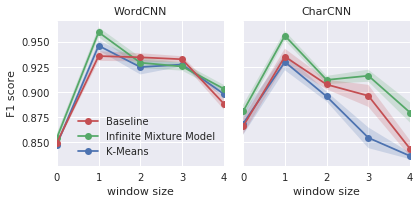

In [37]:
d = {
    "WordCNN": {
        sum(s): {
            'K-Means': old_kmeans_w[s],
            'Infinite Mixture Model': old_gmm_w[s],
            'Baseline': old_baseline[s],
        }
        for s in old_kmeans_w.keys()
    },
    "CharCNN": {
        sum(s): {
            'K-Means': old_char_kmeans_w[s],
            'Infinite Mixture Model': old_char_gmm_w[s],
            'Baseline': old_char_baseline[s],
        }
        for s in old_kmeans_w.keys()
    }
}
#evaluate.analyze_cnns(d, "window_size", "model")
evaluate.analyze_cnns(d, "window size", "model", "../report/figures/results/2000-windowsize-old")

In [13]:
save((old_baseline, old_kmeans_w, old_gmm_w, old_char_baseline, old_char_kmeans_w, old_char_gmm_w), "2000-windowsize-old.pkl")

# Number of clusters, full cross validation

In [ ]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=100,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

optim_fn = lambda p: torch.optim.Adadelta(p)
model_fns = [lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout)]
#             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout)]
    
kmeans = {}
gmm = {}

for num_clusters in [2, 3, 5, 7, 9, 15, 30]:
    window_size = 5
    dataset, validset = load_dataset(num_clusters, window_size)

    values = evaluate.cross_val(10, 1200, model_fns, [False], optim_fn, dataset, params,
                                early_stopping=10,
                                validation_set=validset,
                                testset=None)
    kmeans[num_clusters] = [v[0] for v in values]
    gmm[num_clusters] = [v[1] for v in values]

In [ ]:
d = {s: {'K-Means': kmeans[s],
         #'Mixture model': gmm[s],
        }
    for s in kmeans.keys()
}
#evaluate.analyze_tseries(d, 'k', 'model')
evaluate.analyze_size(d, 'k', 'model', '../report/figures/results/800-numcluster')
evaluate.analyze_tseries(d, 'k', 'model', '../report/figures/results/800-numcluster')

# Number of clusters on old training set

In [15]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=200,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

char_params = train.CharCNNParams(
    dropout=0.5,
    epochs=200,
    max_norm=3,
)

window_size = (0, 1)
k = 5
splitter = evaluate.StratifiedShuffleSplit(
    n_splits=k,
    train_size=2000,
    test_size=None,
    random_state=100,
)

old_kmeans_cls = {}
old_gmm_cls = {}
old_char_kmeans_cls = {}
old_char_gmm_cls = {}

for num_clusters in [2, 3, 5, 7, 9, 15, 30]:
    optim_fn = lambda p: torch.optim.Adadelta(p)
    model_fns = [
        lambda r: models.CategoricalClusterLabels(r, num_clusters, sum(window_size) + 1, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, sum(window_size) + 1, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, num_clusters, sum(window_size) + 1, char_params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, sum(window_size) + 1, char_params.dropout),
    ]

    dataset, validset, testset = evaluate.load_dataset(num_clusters, window_size[0], window_size[1], True)

    splitter.random_state = 100
    values = evaluate.cross_val(k, splitter, model_fns, [False, True, False, True], optim_fn,
                                dataset,
                                params=[params, params, char_params, char_params],
                                early_stopping=2,
                                validation_set=validset,
                                batch_size=128,
                                testset=testset)
    old_kmeans_cls[num_clusters] = [v[0] for v in values]
    old_gmm_cls[num_clusters] = [v[1] for v in values]
    old_char_kmeans_cls[num_clusters] = [v[2] for v in values]
    old_char_gmm_cls[num_clusters] = [v[3] for v in values]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.55it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  55%|█████▌    | 110/200 [01:47<01:28,  1.02it/s, f1=0.944, Δf1=0]       

 20%|██        | 1/5 [03:51<15:24, 231.11s/it]

[3442 1761 2281 ...  231 1316 2548]


Training:  15%|█▌        | 30/200 [00:28<02:43,  1.04it/s, f1=0.929, Δf1=-0.00773]

 40%|████      | 2/5 [05:50<08:45, 175.18s/it]

[  10  683 2628 ... 1125 1557 3658]


Training:  15%|█▌        | 30/200 [00:28<02:42,  1.05it/s, f1=0.947, Δf1=-0.000382]

 60%|██████    | 3/5 [07:34<05:03, 151.50s/it]

[2362 3138 1297 ...  205 2287 1247]


Training:  12%|█▎        | 25/200 [00:23<02:46,  1.05it/s, f1=0.926, Δf1=-0.0193]

 80%|████████  | 4/5 [09:09<02:17, 137.45s/it]

[3690 3243 2192 ... 2801 1146 2757]


Training:  40%|████      | 80/200 [01:16<01:55,  1.04it/s, f1=0.963, Δf1=-0.000268]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.77it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  18%|█▊        | 35/200 [00:33<02:37,  1.05it/s, f1=0.943, Δf1=-0.000426]

 20%|██        | 1/5 [01:36<06:27, 96.78s/it]

[3442 1761 2281 ...  231 1316 2548]


Training:  35%|███▌      | 70/200 [01:06<02:04,  1.05it/s, f1=0.939, Δf1=-0.00109]

 40%|████      | 2/5 [04:24<06:36, 132.12s/it]

[  10  683 2628 ... 1125 1557 3658]


Training:  28%|██▊       | 55/200 [00:52<02:18,  1.05it/s, f1=0.953, Δf1=0]        

 60%|██████    | 3/5 [06:43<04:29, 134.63s/it]

[2362 3138 1297 ...  205 2287 1247]


Training:  45%|████▌     | 90/200 [01:26<01:45,  1.04it/s, f1=0.945, Δf1=0]        

 80%|████████  | 4/5 [09:32<02:23, 143.21s/it]

[3690 3243 2192 ... 2801 1146 2757]


Training:  15%|█▌        | 30/200 [00:28<02:42,  1.05it/s, f1=0.956, Δf1=-0.00221]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.58it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  30%|███       | 60/200 [00:57<02:13,  1.05it/s, f1=0.932, Δf1=0]       

 20%|██        | 1/5 [02:04<08:16, 124.07s/it]

[3442 1761 2281 ...  231 1316 2548]


Training:  32%|███▎      | 65/200 [01:02<02:09,  1.04it/s, f1=0.957, Δf1=0]        

 40%|████      | 2/5 [04:13<06:20, 126.93s/it]

[  10  683 2628 ... 1125 1557 3658]


Training:  45%|████▌     | 90/200 [01:26<01:46,  1.04it/s, f1=0.942, Δf1=0]        

 60%|██████    | 3/5 [07:02<04:41, 140.84s/it]

[2362 3138 1297 ...  205 2287 1247]


Training:  48%|████▊     | 95/200 [01:31<01:41,  1.04it/s, f1=0.933, Δf1=0]       

 80%|████████  | 4/5 [09:48<02:27, 147.00s/it]

[3690 3243 2192 ... 2801 1146 2757]


Training:  12%|█▎        | 25/200 [00:24<02:49,  1.03it/s, f1=0.952, Δf1=-0.000199]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.58it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  32%|███▎      | 65/200 [01:02<02:10,  1.04it/s, f1=0.942, Δf1=0]        

 20%|██        | 1/5 [02:17<09:09, 137.29s/it]

[3442 1761 2281 ...  231 1316 2548]


Training:  45%|████▌     | 90/200 [01:28<01:48,  1.02it/s, f1=0.927, Δf1=0]       

 40%|████      | 2/5 [05:06<07:39, 153.20s/it]

[  10  683 2628 ... 1125 1557 3658]


Training:  48%|████▊     | 95/200 [01:34<01:44,  1.01it/s, f1=0.951, Δf1=0]        

 60%|██████    | 3/5 [07:56<05:17, 158.84s/it]

[2362 3138 1297 ...  205 2287 1247]


Training:  35%|███▌      | 70/200 [01:10<02:10,  1.00s/it, f1=0.928, Δf1=0]        

 80%|████████  | 4/5 [10:13<02:33, 153.34s/it]

[3690 3243 2192 ... 2801 1146 2757]


Training:  12%|█▎        | 25/200 [00:24<02:49,  1.03it/s, f1=0.946, Δf1=-0.00286]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.66it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  28%|██▊       | 55/200 [00:55<02:26,  1.01s/it, f1=0.945, Δf1=-0.000277]

 20%|██        | 1/5 [02:13<08:55, 133.96s/it]

[3442 1761 2281 ...  231 1316 2548]


Training:  10%|█         | 20/200 [00:20<03:06,  1.04s/it, f1=0.943, Δf1=-0.001]

 40%|████      | 2/5 [04:42<07:03, 141.01s/it]

[  10  683 2628 ... 1125 1557 3658]


Training:  25%|██▌       | 50/200 [00:51<02:34,  1.03s/it, f1=0.953, Δf1=-0.000536]

 60%|██████    | 3/5 [07:12<04:48, 144.14s/it]

[2362 3138 1297 ...  205 2287 1247]


Training:  30%|███       | 60/200 [01:03<02:28,  1.06s/it, f1=0.949, Δf1=-0.000103]

 80%|████████  | 4/5 [09:56<02:29, 149.15s/it]

[3690 3243 2192 ... 2801 1146 2757]


Training:  20%|██        | 40/200 [00:39<02:37,  1.02it/s, f1=0.965, Δf1=0]       

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.61it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  20%|██        | 40/200 [00:39<02:37,  1.01it/s, f1=0.942, Δf1=-0.000872]

 20%|██        | 1/5 [02:00<08:02, 120.70s/it]

[3442 1761 2281 ...  231 1316 2548]


Training:  15%|█▌        | 30/200 [00:29<02:48,  1.01it/s, f1=0.955, Δf1=-0.000562]

 40%|████      | 2/5 [03:41<05:31, 110.53s/it]

[  10  683 2628 ... 1125 1557 3658]


Training:  22%|██▎       | 45/200 [00:44<02:31,  1.02it/s, f1=0.944, Δf1=-0.00049] 

 60%|██████    | 3/5 [05:30<03:40, 110.11s/it]

[2362 3138 1297 ...  205 2287 1247]


Training:  22%|██▎       | 45/200 [00:44<02:33,  1.01it/s, f1=0.929, Δf1=-0.00196]

 80%|████████  | 4/5 [07:55<01:58, 118.81s/it]

[3690 3243 2192 ... 2801 1146 2757]


Training:  12%|█▎        | 25/200 [00:25<02:56,  1.01s/it, f1=0.945, Δf1=-0.00156]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.38it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  35%|███▌      | 70/200 [01:16<02:22,  1.10s/it, f1=0.939, Δf1=0]       

 20%|██        | 1/5 [03:13<12:52, 193.23s/it]

[3442 1761 2281 ...  231 1316 2548]


Training:  20%|██        | 40/200 [00:41<02:44,  1.03s/it, f1=0.949, Δf1=-0.000664]

 40%|████      | 2/5 [05:50<08:46, 175.45s/it]

[  10  683 2628 ... 1125 1557 3658]


Training:  40%|████      | 80/200 [01:22<02:04,  1.04s/it, f1=0.954, Δf1=-0.000486]

 60%|██████    | 3/5 [08:39<05:46, 173.21s/it]

[2362 3138 1297 ...  205 2287 1247]


Training:  28%|██▊       | 55/200 [00:59<02:36,  1.08s/it, f1=0.953, Δf1=0]       

 80%|████████  | 4/5 [11:02<02:45, 165.72s/it]

[3690 3243 2192 ... 2801 1146 2757]


Training:  22%|██▎       | 45/200 [00:48<02:47,  1.08s/it, f1=0.957, Δf1=-0.00106] 

100%|██████████| 5/5 [13:48<00:00, 165.70s/it]


In [4]:
(old_kmeans_cls, old_gmm_cls, old_char_kmeans_cls, old_char_gmm_cls) = load("1600-numclusters-old.pkl")

/usr/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


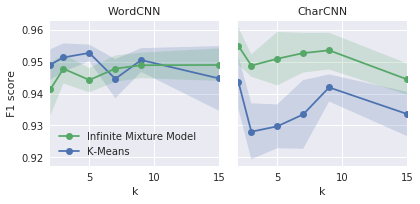

In [36]:
d = {
    "WordCNN": {
        s: {
            'K-Means': old_kmeans_cls[s],
            'Infinite Mixture Model': old_gmm_cls[s],
        }
        for s in old_kmeans_cls.keys()
    },
    "CharCNN": {
        s: {
            'K-Means': old_char_kmeans_cls[s],
            'Infinite Mixture Model': old_char_gmm_cls[s],
        }
        for s in [2, 3, 5, 7, 9, 15]
    }
}
with sns.axes_style("darkgrid"):
    #evaluate.analyze_cnns(d, "k", "model")
    evaluate.analyze_cnns(d, "k", "model", "../report/figures/results/2000-numclusters-old")

In [17]:
save((old_kmeans_cls, old_gmm_cls, old_char_kmeans_cls, old_char_gmm_cls), "2000-numclusters-old.pkl")